In [32]:
import os
import pickle
import keras
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [2]:
import tensorflow_text
import tensorflow as tf
import tensorflow_hub as hub

In [3]:
from keras.callbacks import *
from keras.optimizers import *
from keras import Model
from keras.layers import (
    Lambda, Flatten, Dense, Bidirectional, LSTM,
    Dropout, BatchNormalization, Input
)
from tensorflow.keras.models import load_model
from sklearn.model_selection import StratifiedShuffleSplit

In [4]:
get_embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual/3")
df = pd.read_csv("/kaggle/input/snn-datasets-0x1/df_fs.csv")
df.dropna(inplace=True)
df = df.reset_index(drop=True)
print(df.shape)
df.head()

(4020, 5)


,name,price,category,brand,target
0,aro de aco rolete polegada axion,24.90,complementos,AXION,2
1,luva soldavel com rosca em pvc pol fortlev,1.89,conexoes,FORTLEV,3
2,te reducao esgoto sn em pvc branco fortlev,16.90,conexoes,FORTLEV,3
3,te esgoto sn em pvc branco fortlev,2.59,conexoes,FORTLEV,3
4,ralo sifonado quadrado em pvc xxmm branco fortlev,10.90,conexoes,FORTLEV,3


In [5]:
def split_data(df):
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_valid_idx, test_idx in sss.split(df, df['target']):
        train_valid = df.loc[train_valid_idx].reset_index(drop=True)
        test = df.loc[test_idx].reset_index(drop=True)

    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
    for train_idx, valid_idx in sss.split(train_valid, train_valid['target']):
        train = train_valid.loc[train_idx].reset_index(drop=True)
        valid = train_valid.loc[valid_idx].reset_index(drop=True)

    return train, valid, test


train, test, valid = split_data(df)
embed_dim = get_embed(train.loc[:1, 'name'].values.tolist()).shape[1]
print(f"train: {train.shape}, test: {test.shape}, valid: {valid.shape}, embe: {embed_dim}")
print(train.shape, test.shape, valid.shape)

train: (2412, 5), test: (804, 5), valid: (804, 5), embe: 512
(2412, 5) (804, 5) (804, 5)


In [13]:
class L2NormalizeLayer(keras.Layer):
    def __init__(self, **kwargs):
        super(L2NormalizeLayer, self).__init__(**kwargs)

    def call(self, inputs):
        return tf.math.l2_normalize(inputs, axis=1)

class TripletLossBlock(keras.Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossBlock, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        a, p, n = inputs
        p_dist = keras.ops.sum(keras.ops.square(a - p), axis=-1)
        n_dist = keras.ops.sum(keras.ops.square(a - n), axis=-1)
        return keras.ops.sum(keras.ops.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

def build_model(hp):
    input_one = Input(shape=(embed_dim,))
    
    x = Dense(units=hp["dense1_units"], activation='relu')(input_one)
    x = Dropout(hp['dropout1'])(x)
    x = BatchNormalization()(x)
    
    x = Dense(units=hp["dense2_units"], activation='relu', 
              kernel_regularizer=tf.keras.regularizers.l2(hp["l2_reg"]))(x)
    x = Dropout(hp['dropout2'])(x)

    x = Dense(units=hp["dense3_units"], activation='relu')(input_one)
    x = Dropout(hp['dropout3'])(x)
    x = BatchNormalization()(x)
    
    dense_layer_final = Dense(units=hp['dense_layer_final'], name='dense_layer_final')(x)
    norm_layer = L2NormalizeLayer(name='norm_layer')(dense_layer_final)
    
    base_model = Model(inputs=input_one, outputs=norm_layer, name='base_model')
    
    input_a = Input(shape=(embed_dim,))
    input_p = Input(shape=(embed_dim,))
    input_n = Input(shape=(embed_dim,))
    
    embed_a = base_model(input_a)
    embed_p = base_model(input_p)
    embed_n = base_model(input_n)
    
    triplet_loss = TripletLossBlock(
        alpha=hp['alpha'], name='triplet_loss_block')([embed_a, embed_p, embed_n])
    
    snn_model = Model([input_a, input_p, input_n], triplet_loss)
    
    snn_model.compile(
        optimizer=keras.optimizers.Adam(hp['learning_rate']),
        loss=None
    )
    
    return snn_model

In [63]:
def get_triplets(unique_labels, label_indices_map):
    label_l, label_r = np.random.choice(unique_labels, 2, replace=False)
    a, p = np.random.choice(label_indices_map[label_l], 2, replace=False)
    n = np.random.choice(label_indices_map[label_r])
    return a, p, n

def get_batch(batch_size, dataset, unique_labels, label_indices_map, get_embed):
    while True:
        idxs_a, idxs_p, idxs_n = [], [], []
        for _ in range(batch_size):
            a, p, n = get_triplets(unique_labels, label_indices_map)
            idxs_a.append(a)
            idxs_p.append(p)
            idxs_n.append(n)

        a = dataset.iloc[idxs_a].values.tolist()
        b = dataset.iloc[idxs_p].values.tolist()
        c = dataset.iloc[idxs_n].values.tolist()

        a = get_embed(a).numpy()
        p = get_embed(b).numpy()
        n = get_embed(c).numpy()

        yield a, p, n

def create_label_indices_map(dataset, collabel):
    unique_labels = np.array(dataset[collabel].unique().tolist())
    labels = np.array(dataset[collabel].tolist())
    label_indices_map = {
        label: np.flatnonzero(labels == label)
        for label in unique_labels
    }
    return unique_labels, label_indices_map

def triplet_generator(batch_size, dataset, unique_labels, label_indices_map, get_embed):
    while True:
        for a, p, n in get_batch(batch_size, dataset, unique_labels, label_indices_map, get_embed):
            yield (a, p, n), np.zeros((batch_size,))

def create_trip_dtset(batch_size, dataset, colfeat, collabel, get_embed, embed_dim=512):
    unique_labels, label_indices_map = create_label_indices_map(dataset, collabel)
    
    output_signature = (
        (
            tf.TensorSpec(shape=(None, embed_dim), dtype=tf.float32),
            tf.TensorSpec(shape=(None, embed_dim), dtype=tf.float32),
            tf.TensorSpec(shape=(None, embed_dim), dtype=tf.float32)
        ),
        tf.TensorSpec(shape=(None,), dtype=tf.float32)
    )
    
    dataset_tf = tf.data.Dataset.from_generator(
        lambda: triplet_generator(
            batch_size, dataset[colfeat], unique_labels, label_indices_map, get_embed),
        output_signature=output_signature
    )
    return dataset_tf

In [64]:
batch_size, colfeat, collabel = 64, 'name', 'target'
dataset_train = create_trip_dtset(batch_size, train, colfeat, collabel, get_embed, embed_dim)
dataset_val = create_trip_dtset(batch_size, valid, colfeat, collabel, get_embed, embed_dim)
steps = len(train) // batch_size
dataset_train

<_FlatMapDataset element_spec=((TensorSpec(shape=(None, 512), dtype=tf.float32, name=None), TensorSpec(shape=(None, 512), dtype=tf.float32, name=None), TensorSpec(shape=(None, 512), dtype=tf.float32, name=None)), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [65]:
hps ={ 
    "dense1_units": 256, "dense2_units": 64, "dense3_units": 256,
    "dense_layer_final": 128,
    "dropout1": 0.2, "dropout2": 0.4, "dropout3": 0.4, "l2_reg": 0.007347869869871025, 
    "alpha": 0.2, "learning_rate": 0.0028505050405801123
}

In [66]:
snn_model = build_model(hps)

checkpoint = ModelCheckpoint(
    filepath='main_snn_model.keras',
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

histories = snn_model.fit(
    dataset_train,
    epochs=100,
    steps_per_epoch=steps,
    validation_data=dataset_val,
    validation_steps=steps,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/100
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 5.8142
Epoch 1: val_loss improved from inf to 1.84021, saving model to main_snn_model.keras
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - loss: 5.7397 - val_loss: 1.8402
Epoch 2/100
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 2.6874
Epoch 2: val_loss improved from 1.84021 to 1.56689, saving model to main_snn_model.keras
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 2.6723 - val_loss: 1.5669
Epoch 3/100
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.4787
Epoch 3: val_loss improved from 1.56689 to 0.97211, saving model to main_snn_model.keras
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 1.4759 - val_loss: 0.9721
Epoch 4/100
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.1617
Epoch 4: val_loss did not improve from 0.97211
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 1.1614 - val_loss: 1.1782
Epoch 5/100
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.0073
Epoch 5: val_loss improved from 0.97211 to 0.95962, saving 

In [67]:
base_snn_model = load_model(
    'main_snn_model.keras', 
    custom_objects={
    'L2NormalizeLayer': L2NormalizeLayer,
    'TripletLossBlock': TripletLossBlock
})
base_model = snn_model.get_layer('base_model')
base_model.summary()

Model: "base_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_layer_final (Dense)            │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ norm_layer (L2NormalizeLayer)        │ (None, 128)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 165,248 (645.50 KB)

 Trainable params: 164,736 (643.50 KB)

 Non-trainable params: 512 (2.00 KB)

In [68]:
#X_train = base_model.predict(get_embed(valid['name'].values.tolist()).numpy())
X_emb_pred = base_model.predict(get_embed(test['name'].tolist()).numpy())
X_emb_use = get_embed(test['name'].values.tolist()).numpy()

#y_train = np.array(valid['target'].values.tolist())
y_test = np.array(test['target'].values.tolist())

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [69]:
def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=0.6)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      annot=True,
      fmt=".2f",
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Similaridade Semantica")

def run_plot(text):
  text_embeds = base_model.predict(get_embed(text).numpy())
  plot_similarity(text, text_embeds, 90)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


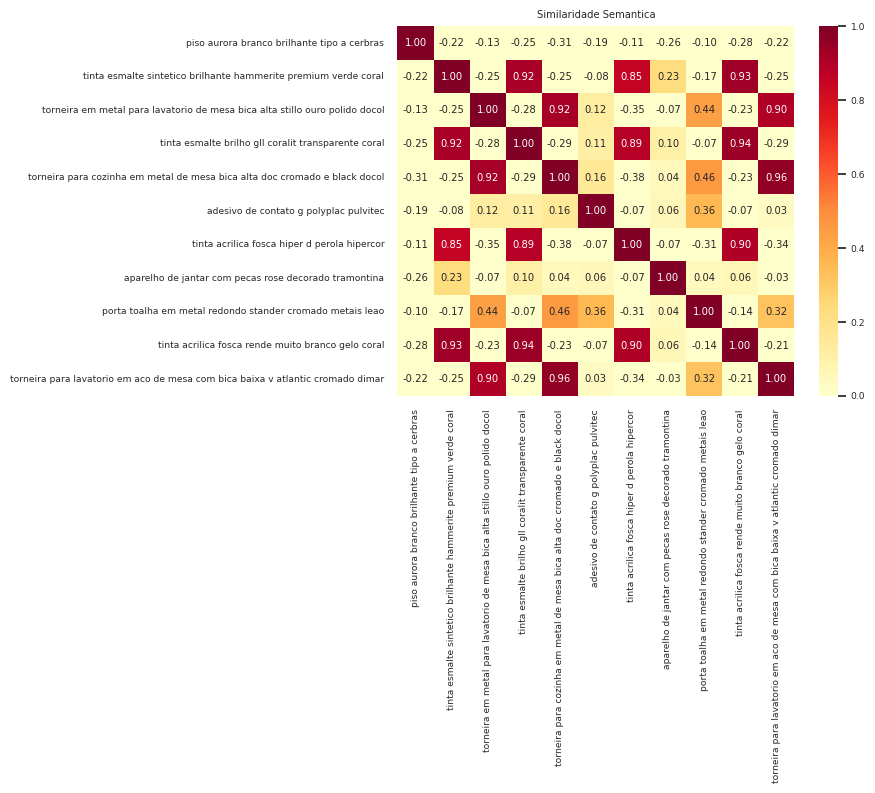

In [70]:
run_plot(test.loc[:10, 'name'].tolist())

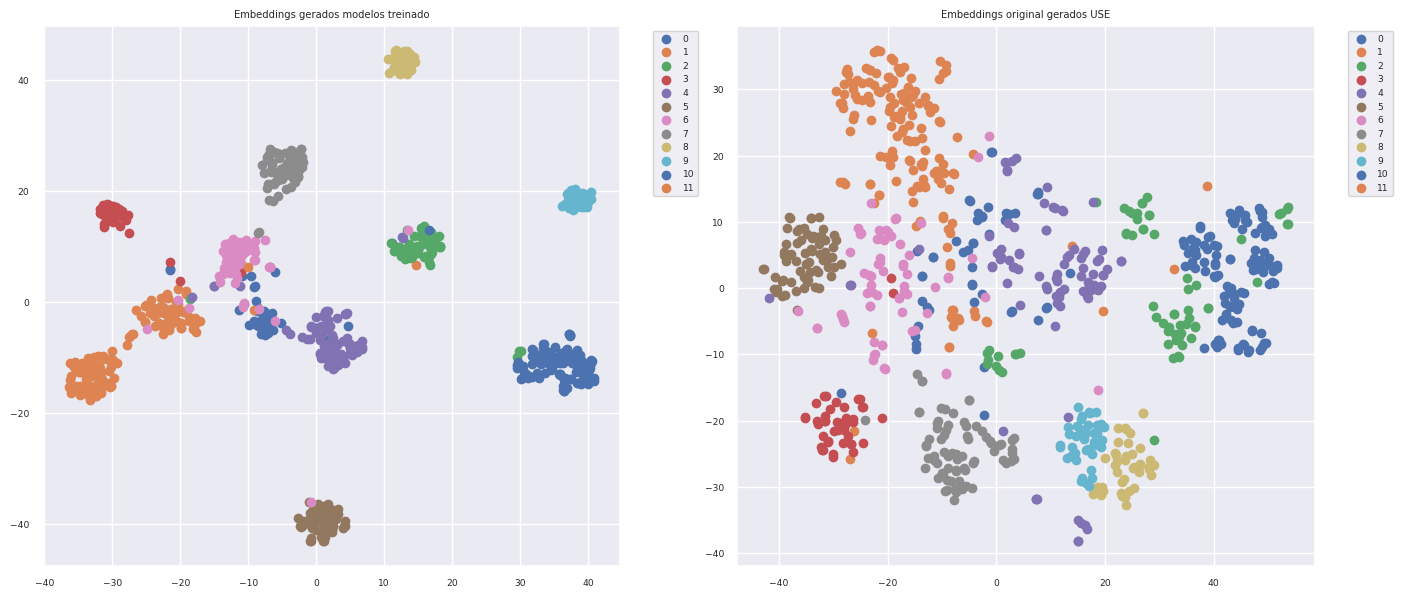

In [71]:
X_embed_p = TSNE(n_components=2).fit_transform(X_emb_pred)
X_embed = TSNE(n_components=2).fit_transform(X_emb_use)

fig, axes = plt.subplots(1, 2, figsize=(14, 6)) 

for i, t in enumerate(set(y_test)):
    idx = y_test == t
    axes[0].scatter(X_embed_p[idx, 0], X_embed_p[idx, 1], label=t)
axes[0].set_title("Embeddings gerados modelos treinado")
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

for i, t in enumerate(set(y_test)):
    idx = y_test == t
    axes[1].scatter(X_embed[idx, 0], X_embed[idx, 1], label=t)
axes[1].set_title("Embeddings original gerados USE")
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()